In [124]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Step 1 : Data Acquisition

### License

Code Owner : Dr. David W. McDonald 

Creative Commons CC-BY license. Revision 1.2 - August 14, 2023

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<prerit16@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
#ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}


In [3]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [4]:
data = pd.read_excel('../Data/thank_the_academy.AUG.2023.csv.xlsx')

In [5]:
data

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Every...
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the...
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_...
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_W...
...,...,...
1354,The Yankee Doodle Mouse,https://en.wikipedia.org/wiki/The_Yankee_Doodl...
1355,The Yearling (1946 film),https://en.wikipedia.org/wiki/The_Yearling_(19...
1356,"Yesterday, Today and Tomorrow","https://en.wikipedia.org/wiki/Yesterday,_Today..."
1357,You Can't Take It with You (film),https://en.wikipedia.org/wiki/You_Can't_Take_I...


In [6]:
len(data)

1359

In [7]:
access = ['all-access','desktop','mobile-web','mobile-app']
#filtered_data = pd.DataFrame(columns = ['project','article','granularity','timestamp','access','agent','views'])
filtered_data = []
for index, row in data.iterrows():
    try: 
        for i in access:
            ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = i
            views = request_pageviews_per_article(row['name'])
            filtered_data.append(pd.json_normalize(views['items']))
            print(f"Data Fetched for {row['name']}")
    except:
        print(f"Request Failed for {row['name']}")

Data Fetched for Everything Everywhere All at Once
Data Fetched for Everything Everywhere All at Once
Data Fetched for Everything Everywhere All at Once
Data Fetched for Everything Everywhere All at Once
Data Fetched for All Quiet on the Western Front (2022 film)
Data Fetched for All Quiet on the Western Front (2022 film)
Data Fetched for All Quiet on the Western Front (2022 film)
Data Fetched for All Quiet on the Western Front (2022 film)
Data Fetched for The Whale (2022 film)
Data Fetched for The Whale (2022 film)
Data Fetched for The Whale (2022 film)
Data Fetched for The Whale (2022 film)
Data Fetched for Top Gun: Maverick
Data Fetched for Top Gun: Maverick
Data Fetched for Top Gun: Maverick
Data Fetched for Top Gun: Maverick
Data Fetched for Black Panther: Wakanda Forever
Data Fetched for Black Panther: Wakanda Forever
Data Fetched for Black Panther: Wakanda Forever
Data Fetched for Black Panther: Wakanda Forever
Data Fetched for Avatar: The Way of Water
Data Fetched for Avatar: T

Data Fetched for Once Upon a Time in Hollywood
Data Fetched for Once Upon a Time in Hollywood
Data Fetched for 1917 (2019 film)
Data Fetched for 1917 (2019 film)
Data Fetched for 1917 (2019 film)
Data Fetched for 1917 (2019 film)
Data Fetched for Judy (film)
Data Fetched for Judy (film)
Data Fetched for Judy (film)
Data Fetched for Judy (film)
Data Fetched for Bombshell (2019 film)
Data Fetched for Bombshell (2019 film)
Data Fetched for Bombshell (2019 film)
Data Fetched for Bombshell (2019 film)
Data Fetched for Rocketman (film)
Data Fetched for Rocketman (film)
Data Fetched for Rocketman (film)
Data Fetched for Rocketman (film)
Data Fetched for American Factory
Data Fetched for American Factory
Data Fetched for American Factory
Data Fetched for American Factory
Data Fetched for Hair Love
Data Fetched for Hair Love
Data Fetched for Hair Love
Data Fetched for Hair Love
Data Fetched for Green Book (film)
Data Fetched for Green Book (film)
Data Fetched for Green Book (film)
Data Fetched 

Data Fetched for The Revenant (2015 film)
Data Fetched for The Revenant (2015 film)
Data Fetched for Bridge of Spies (film)
Data Fetched for Bridge of Spies (film)
Data Fetched for Bridge of Spies (film)
Data Fetched for Bridge of Spies (film)
Data Fetched for The Big Short (film)
Data Fetched for The Big Short (film)
Data Fetched for The Big Short (film)
Data Fetched for The Big Short (film)
Data Fetched for The Danish Girl (film)
Data Fetched for The Danish Girl (film)
Data Fetched for The Danish Girl (film)
Data Fetched for The Danish Girl (film)
Data Fetched for Room (2015 film)
Data Fetched for Room (2015 film)
Data Fetched for Room (2015 film)
Data Fetched for Room (2015 film)
Data Fetched for The Hateful Eight
Data Fetched for The Hateful Eight
Data Fetched for The Hateful Eight
Data Fetched for The Hateful Eight
Data Fetched for Ex Machina (film)
Data Fetched for Ex Machina (film)
Data Fetched for Ex Machina (film)
Data Fetched for Ex Machina (film)
Data Fetched for Inside Out 

Data Fetched for The Artist (film)
Data Fetched for The Artist (film)
Data Fetched for Hugo (film)
Data Fetched for Hugo (film)
Data Fetched for Hugo (film)
Data Fetched for Hugo (film)
Data Fetched for The Iron Lady (film)
Data Fetched for The Iron Lady (film)
Data Fetched for The Iron Lady (film)
Data Fetched for The Iron Lady (film)
Data Fetched for The Descendants
Data Fetched for The Descendants
Data Fetched for The Descendants
Data Fetched for The Descendants
Data Fetched for The Girl with the Dragon Tattoo (2011 film)
Data Fetched for The Girl with the Dragon Tattoo (2011 film)
Data Fetched for The Girl with the Dragon Tattoo (2011 film)
Data Fetched for The Girl with the Dragon Tattoo (2011 film)
Data Fetched for Midnight in Paris
Data Fetched for Midnight in Paris
Data Fetched for Midnight in Paris
Data Fetched for Midnight in Paris
Data Fetched for The Help (film)
Data Fetched for The Help (film)
Data Fetched for The Help (film)
Data Fetched for The Help (film)
Data Fetched f

Data Fetched for The Bourne Ultimatum (film)
Data Fetched for The Bourne Ultimatum (film)
Data Fetched for The Bourne Ultimatum (film)
Data Fetched for There Will Be Blood
Data Fetched for There Will Be Blood
Data Fetched for There Will Be Blood
Data Fetched for There Will Be Blood
Data Fetched for La Vie en rose (film)
Data Fetched for La Vie en rose (film)
Data Fetched for La Vie en rose (film)
Data Fetched for La Vie en rose (film)
Data Fetched for Atonement (2007 film)
Data Fetched for Atonement (2007 film)
Data Fetched for Atonement (2007 film)
Data Fetched for Atonement (2007 film)
Data Fetched for Michael Clayton (film)
Data Fetched for Michael Clayton (film)
Data Fetched for Michael Clayton (film)
Data Fetched for Michael Clayton (film)
Data Fetched for Ratatouille (film)
Data Fetched for Ratatouille (film)
Data Fetched for Ratatouille (film)
Data Fetched for Ratatouille (film)
Data Fetched for Juno (film)
Data Fetched for Juno (film)
Data Fetched for Juno (film)
Data Fetched f

Data Fetched for Ray (film)
Data Fetched for Ray (film)
Data Fetched for Ray (film)
Data Fetched for The Incredibles
Data Fetched for The Incredibles
Data Fetched for The Incredibles
Data Fetched for The Incredibles
Data Fetched for Finding Neverland (film)
Data Fetched for Finding Neverland (film)
Data Fetched for Finding Neverland (film)
Data Fetched for Finding Neverland (film)
Data Fetched for Sideways
Data Fetched for Sideways
Data Fetched for Sideways
Data Fetched for Sideways
Data Fetched for Lemony Snicket's A Series of Unfortunate Events
Data Fetched for Lemony Snicket's A Series of Unfortunate Events
Data Fetched for Lemony Snicket's A Series of Unfortunate Events
Data Fetched for Lemony Snicket's A Series of Unfortunate Events
Data Fetched for Spider-Man 2
Data Fetched for Spider-Man 2
Data Fetched for Spider-Man 2
Data Fetched for Spider-Man 2
Data Fetched for Eternal Sunshine of the Spotless Mind
Data Fetched for Eternal Sunshine of the Spotless Mind
Data Fetched for Etern

Data Fetched for Murder on a Sunday Morning
Data Fetched for Murder on a Sunday Morning
Data Fetched for Murder on a Sunday Morning
Data Fetched for The Accountant (2001 film)
Data Fetched for The Accountant (2001 film)
Data Fetched for The Accountant (2001 film)
Data Fetched for The Accountant (2001 film)
Data Fetched for Gladiator (2000 film)
Data Fetched for Gladiator (2000 film)
Data Fetched for Gladiator (2000 film)
Data Fetched for Gladiator (2000 film)
Data Fetched for Crouching Tiger, Hidden Dragon
Data Fetched for Crouching Tiger, Hidden Dragon
Data Fetched for Crouching Tiger, Hidden Dragon
Data Fetched for Crouching Tiger, Hidden Dragon
Data Fetched for Traffic (2000 film)
Data Fetched for Traffic (2000 film)
Data Fetched for Traffic (2000 film)
Data Fetched for Traffic (2000 film)
Data Fetched for Erin Brockovich (film)
Data Fetched for Erin Brockovich (film)
Data Fetched for Erin Brockovich (film)
Data Fetched for Erin Brockovich (film)
Data Fetched for Almost Famous
Data 

Data Fetched for The Long Way Home (1997 film)
Data Fetched for The Long Way Home (1997 film)
Data Fetched for The Long Way Home (1997 film)
Data Fetched for The English Patient (film)
Data Fetched for The English Patient (film)
Data Fetched for The English Patient (film)
Data Fetched for The English Patient (film)
Data Fetched for Fargo (1996 film)
Data Fetched for Fargo (1996 film)
Data Fetched for Fargo (1996 film)
Data Fetched for Fargo (1996 film)
Data Fetched for Shine (film)
Data Fetched for Shine (film)
Data Fetched for Shine (film)
Data Fetched for Shine (film)
Data Fetched for Evita (1996 film)
Data Fetched for Evita (1996 film)
Data Fetched for Evita (1996 film)
Data Fetched for Evita (1996 film)
Data Fetched for Jerry Maguire
Data Fetched for Jerry Maguire
Data Fetched for Jerry Maguire
Data Fetched for Jerry Maguire
Data Fetched for Independence Day (1996 film)
Data Fetched for Independence Day (1996 film)
Data Fetched for Independence Day (1996 film)
Data Fetched for Inde

Data Fetched for The Age of Innocence (1993 film)
Data Fetched for The Age of Innocence (1993 film)
Data Fetched for The Age of Innocence (1993 film)
Data Fetched for The Wrong Trousers
Data Fetched for The Wrong Trousers
Data Fetched for The Wrong Trousers
Data Fetched for The Wrong Trousers
Data Fetched for Belle Epoque (film)
Data Fetched for Belle Epoque (film)
Data Fetched for Belle Epoque (film)
Data Fetched for Belle Epoque (film)
Data Fetched for I Am a Promise: The Children of Stanton Elementary School
Data Fetched for I Am a Promise: The Children of Stanton Elementary School
Data Fetched for I Am a Promise: The Children of Stanton Elementary School
Data Fetched for I Am a Promise: The Children of Stanton Elementary School
Data Fetched for Mrs. Doubtfire
Data Fetched for Mrs. Doubtfire
Data Fetched for Mrs. Doubtfire
Data Fetched for Mrs. Doubtfire
Data Fetched for Schwarzfahrer
Data Fetched for Schwarzfahrer
Data Fetched for Schwarzfahrer
Data Fetched for Schwarzfahrer
Data F

Data Fetched for Born on the Fourth of July (film)
Data Fetched for Born on the Fourth of July (film)
Data Fetched for Born on the Fourth of July (film)
Data Fetched for My Left Foot
Data Fetched for My Left Foot
Data Fetched for My Left Foot
Data Fetched for My Left Foot
Data Fetched for The Little Mermaid (1989 film)
Data Fetched for The Little Mermaid (1989 film)
Data Fetched for The Little Mermaid (1989 film)
Data Fetched for The Little Mermaid (1989 film)
Data Fetched for Dead Poets Society
Data Fetched for Dead Poets Society
Data Fetched for Dead Poets Society
Data Fetched for Dead Poets Society
Data Fetched for The Abyss
Data Fetched for The Abyss
Data Fetched for The Abyss
Data Fetched for The Abyss
Data Fetched for Indiana Jones and the Last Crusade
Data Fetched for Indiana Jones and the Last Crusade
Data Fetched for Indiana Jones and the Last Crusade
Data Fetched for Indiana Jones and the Last Crusade
Data Fetched for Henry V (1989 film)
Data Fetched for Henry V (1989 film)
D

Data Fetched for The Assault (1986 film)
Data Fetched for Down and Out in America
Data Fetched for Down and Out in America
Data Fetched for Down and Out in America
Data Fetched for Down and Out in America
Data Fetched for The Fly (1986 film)
Data Fetched for The Fly (1986 film)
Data Fetched for The Fly (1986 film)
Data Fetched for The Fly (1986 film)
Data Fetched for A Greek Tragedy
Data Fetched for A Greek Tragedy
Data Fetched for A Greek Tragedy
Data Fetched for A Greek Tragedy
Data Fetched for Precious Images
Data Fetched for Precious Images
Data Fetched for Precious Images
Data Fetched for Precious Images
Data Fetched for Women – for America, for the World
Data Fetched for Women – for America, for the World
Data Fetched for Women – for America, for the World
Data Fetched for Women – for America, for the World
Data Fetched for Out of Africa (film)
Data Fetched for Out of Africa (film)
Data Fetched for Out of Africa (film)
Data Fetched for Out of Africa (film)
Data Fetched for Witnes

Data Fetched for A Shocking Accident
Data Fetched for A Shocking Accident
Data Fetched for A Shocking Accident
Data Fetched for Tango (1981 film)
Data Fetched for Tango (1981 film)
Data Fetched for Tango (1981 film)
Data Fetched for Tango (1981 film)
Data Fetched for Begin the Beguine (film)
Data Fetched for Begin the Beguine (film)
Data Fetched for Begin the Beguine (film)
Data Fetched for Begin the Beguine (film)
Data Fetched for Quest for Fire (film)
Data Fetched for Quest for Fire (film)
Data Fetched for Quest for Fire (film)
Data Fetched for Quest for Fire (film)
Data Fetched for Chariots of Fire
Data Fetched for Chariots of Fire
Data Fetched for Chariots of Fire
Data Fetched for Chariots of Fire
Data Fetched for Raiders of the Lost Ark
Data Fetched for Raiders of the Lost Ark
Data Fetched for Raiders of the Lost Ark
Data Fetched for Raiders of the Lost Ark
Data Fetched for Reds (film)
Data Fetched for Reds (film)
Data Fetched for Reds (film)
Data Fetched for Reds (film)
Data Fetc

Data Fetched for Thank God It's Friday (film)
Data Fetched for Thank God It's Friday (film)
Data Fetched for Thank God It's Friday (film)
Data Fetched for Superman (1978 film)
Data Fetched for Superman (1978 film)
Data Fetched for Superman (1978 film)
Data Fetched for Superman (1978 film)
Data Fetched for Annie Hall
Data Fetched for Annie Hall
Data Fetched for Annie Hall
Data Fetched for Annie Hall
Data Fetched for Star Wars (film)
Data Fetched for Star Wars (film)
Data Fetched for Star Wars (film)
Data Fetched for Star Wars (film)
Data Fetched for Julia (1977 film)
Data Fetched for Julia (1977 film)
Data Fetched for Julia (1977 film)
Data Fetched for Julia (1977 film)
Data Fetched for Close Encounters of the Third Kind
Data Fetched for Close Encounters of the Third Kind
Data Fetched for Close Encounters of the Third Kind
Data Fetched for Close Encounters of the Third Kind
Data Fetched for The Goodbye Girl
Data Fetched for The Goodbye Girl
Data Fetched for The Goodbye Girl
Data Fetched

Data Fetched for Hearts and Minds (film)
Data Fetched for One-Eyed Men Are Kings
Data Fetched for One-Eyed Men Are Kings
Data Fetched for One-Eyed Men Are Kings
Data Fetched for One-Eyed Men Are Kings
Data Fetched for The Sting
Data Fetched for The Sting
Data Fetched for The Sting
Data Fetched for The Sting
Data Fetched for The Exorcist (film)
Data Fetched for The Exorcist (film)
Data Fetched for The Exorcist (film)
Data Fetched for The Exorcist (film)
Data Fetched for The Way We Were
Data Fetched for The Way We Were
Data Fetched for The Way We Were
Data Fetched for The Way We Were
Data Fetched for Cries and Whispers
Data Fetched for Cries and Whispers
Data Fetched for Cries and Whispers
Data Fetched for Cries and Whispers
Data Fetched for A Touch of Class (film)
Data Fetched for A Touch of Class (film)
Data Fetched for A Touch of Class (film)
Data Fetched for A Touch of Class (film)
Data Fetched for Day for Night (film)
Data Fetched for Day for Night (film)
Data Fetched for Day for Ni

Data Fetched for Let It Be (1970 film)
Data Fetched for Let It Be (1970 film)
Data Fetched for The Resurrection of Broncho Billy
Data Fetched for The Resurrection of Broncho Billy
Data Fetched for The Resurrection of Broncho Billy
Data Fetched for The Resurrection of Broncho Billy
Data Fetched for Midnight Cowboy
Data Fetched for Midnight Cowboy
Data Fetched for Midnight Cowboy
Data Fetched for Midnight Cowboy
Data Fetched for Butch Cassidy and the Sundance Kid
Data Fetched for Butch Cassidy and the Sundance Kid
Data Fetched for Butch Cassidy and the Sundance Kid
Data Fetched for Butch Cassidy and the Sundance Kid
Data Fetched for Hello, Dolly! (film)
Data Fetched for Hello, Dolly! (film)
Data Fetched for Hello, Dolly! (film)
Data Fetched for Hello, Dolly! (film)
Data Fetched for Z (1969 film)
Data Fetched for Z (1969 film)
Data Fetched for Z (1969 film)
Data Fetched for Z (1969 film)
Data Fetched for Anne of the Thousand Days
Data Fetched for Anne of the Thousand Days
Data Fetched for

Data Fetched for Fantastic Voyage
Data Fetched for Fantastic Voyage
Data Fetched for Fantastic Voyage
Data Fetched for A Man and a Woman
Data Fetched for A Man and a Woman
Data Fetched for A Man and a Woman
Data Fetched for A Man and a Woman
Data Fetched for Born Free
Data Fetched for Born Free
Data Fetched for Born Free
Data Fetched for Born Free
Data Fetched for The Fortune Cookie
Data Fetched for The Fortune Cookie
Data Fetched for The Fortune Cookie
Data Fetched for The Fortune Cookie
Data Fetched for A Funny Thing Happened on the Way to the Forum (film)
Data Fetched for A Funny Thing Happened on the Way to the Forum (film)
Data Fetched for A Funny Thing Happened on the Way to the Forum (film)
Data Fetched for A Funny Thing Happened on the Way to the Forum (film)
Data Fetched for A Herb Alpert and the Tijuana Brass Double Feature
Data Fetched for A Herb Alpert and the Tijuana Brass Double Feature
Data Fetched for A Herb Alpert and the Tijuana Brass Double Feature
Data Fetched for A

Data Fetched for The Bad and the Beautiful
Data Fetched for The Bad and the Beautiful
Data Fetched for Bad Girl (1931 film)
Data Fetched for Bad Girl (1931 film)
Data Fetched for Bad Girl (1931 film)
Data Fetched for Bad Girl (1931 film)
Data Fetched for The Barefoot Contessa
Data Fetched for The Barefoot Contessa
Data Fetched for The Barefoot Contessa
Data Fetched for The Barefoot Contessa
Data Fetched for The Battle of Midway (film)
Data Fetched for The Battle of Midway (film)
Data Fetched for The Battle of Midway (film)
Data Fetched for The Battle of Midway (film)
Data Fetched for Battleground (film)
Data Fetched for Battleground (film)
Data Fetched for Battleground (film)
Data Fetched for Battleground (film)
Data Fetched for Bear Country (film)
Data Fetched for Bear Country (film)
Data Fetched for Bear Country (film)
Data Fetched for Bear Country (film)
Data Fetched for Becket (1964 film)
Data Fetched for Becket (1964 film)
Data Fetched for Becket (1964 film)
Data Fetched for Becke

Data Fetched for The Champ (1931 film)
Data Fetched for The Champ (1931 film)
Data Fetched for The Champ (1931 film)
Data Fetched for Champion (1949 film)
Data Fetched for Champion (1949 film)
Data Fetched for Champion (1949 film)
Data Fetched for Champion (1949 film)
Data Fetched for A Chance to Live
Data Fetched for A Chance to Live
Data Fetched for A Chance to Live
Data Fetched for A Chance to Live
Data Fetched for The Charge of the Light Brigade (1936 film)
Data Fetched for The Charge of the Light Brigade (1936 film)
Data Fetched for The Charge of the Light Brigade (1936 film)
Data Fetched for The Charge of the Light Brigade (1936 film)
Data Fetched for The Chicken (film)
Data Fetched for The Chicken (film)
Data Fetched for The Chicken (film)
Data Fetched for The Chicken (film)
Data Fetched for Churchill's Island
Data Fetched for Churchill's Island
Data Fetched for Churchill's Island
Data Fetched for Churchill's Island
Data Fetched for Cimarron (1931 film)
Data Fetched for Cimarron

Data Fetched for East of Eden (film)
Data Fetched for East of Eden (film)
Data Fetched for East of Eden (film)
Data Fetched for Easter Parade (film)
Data Fetched for Easter Parade (film)
Data Fetched for Easter Parade (film)
Data Fetched for Easter Parade (film)
Data Fetched for Elmer Gantry (film)
Data Fetched for Elmer Gantry (film)
Data Fetched for Elmer Gantry (film)
Data Fetched for Elmer Gantry (film)
Data Fetched for The Enemy Below
Data Fetched for The Enemy Below
Data Fetched for The Enemy Below
Data Fetched for The Enemy Below
Data Fetched for Eskimo (1933 film)
Data Fetched for Eskimo (1933 film)
Data Fetched for Eskimo (1933 film)
Data Fetched for Eskimo (1933 film)
Data Fetched for Exodus (1960 film)
Data Fetched for Exodus (1960 film)
Data Fetched for Exodus (1960 film)
Data Fetched for Exodus (1960 film)
Data Fetched for The Face of Lincoln
Data Fetched for The Face of Lincoln
Data Fetched for The Face of Lincoln
Data Fetched for The Face of Lincoln
Data Fetched for Faci

Data Fetched for The Great Waltz (1938 film)
Data Fetched for The Great Ziegfeld
Data Fetched for The Great Ziegfeld
Data Fetched for The Great Ziegfeld
Data Fetched for The Great Ziegfeld
Data Fetched for The Greatest Show on Earth (film)
Data Fetched for The Greatest Show on Earth (film)
Data Fetched for The Greatest Show on Earth (film)
Data Fetched for The Greatest Show on Earth (film)
Data Fetched for Green Dolphin Street (film)
Data Fetched for Green Dolphin Street (film)
Data Fetched for Green Dolphin Street (film)
Data Fetched for Green Dolphin Street (film)
Data Fetched for The Guns of Navarone (film)
Data Fetched for The Guns of Navarone (film)
Data Fetched for The Guns of Navarone (film)
Data Fetched for The Guns of Navarone (film)
Data Fetched for Hamlet (1948 film)
Data Fetched for Hamlet (1948 film)
Data Fetched for Hamlet (1948 film)
Data Fetched for Hamlet (1948 film)
Data Fetched for Heureux Anniversaire
Data Fetched for Heureux Anniversaire
Data Fetched for Heureux An

Data Fetched for Julius Caesar (1953 film)
Data Fetched for Julius Caesar (1953 film)
Data Fetched for Julius Caesar (1953 film)
Data Fetched for Kentucky (film)
Data Fetched for Kentucky (film)
Data Fetched for Kentucky (film)
Data Fetched for Kentucky (film)
Data Fetched for Key Largo (film)
Data Fetched for Key Largo (film)
Data Fetched for Key Largo (film)
Data Fetched for Key Largo (film)
Data Fetched for The King and I (1956 film)
Data Fetched for The King and I (1956 film)
Data Fetched for The King and I (1956 film)
Data Fetched for The King and I (1956 film)
Data Fetched for King of Jazz
Data Fetched for King of Jazz
Data Fetched for King of Jazz
Data Fetched for King of Jazz
Data Fetched for King Solomon's Mines (1950 film)
Data Fetched for King Solomon's Mines (1950 film)
Data Fetched for King Solomon's Mines (1950 film)
Data Fetched for King Solomon's Mines (1950 film)
Data Fetched for Kitty Foyle (film)
Data Fetched for Kitty Foyle (film)
Data Fetched for Kitty Foyle (film)

Data Fetched for Miracle on 34th Street
Data Fetched for Miracle on 34th Street
Data Fetched for Miracle on 34th Street
Data Fetched for The Miracle Worker (1962 film)
Data Fetched for The Miracle Worker (1962 film)
Data Fetched for The Miracle Worker (1962 film)
Data Fetched for The Miracle Worker (1962 film)
Data Fetched for Mister Roberts (1955 film)
Data Fetched for Mister Roberts (1955 film)
Data Fetched for Mister Roberts (1955 film)
Data Fetched for Mister Roberts (1955 film)
Data Fetched for Monsieur Vincent
Data Fetched for Monsieur Vincent
Data Fetched for Monsieur Vincent
Data Fetched for Monsieur Vincent
Data Fetched for Moonbird
Data Fetched for Moonbird
Data Fetched for Moonbird
Data Fetched for Moonbird
Data Fetched for The More the Merrier
Data Fetched for The More the Merrier
Data Fetched for The More the Merrier
Data Fetched for The More the Merrier
Data Fetched for Morning Glory (1933 film)
Data Fetched for Morning Glory (1933 film)
Data Fetched for Morning Glory (19

Data Fetched for Picnic (1955 film)
Data Fetched for Picnic (1955 film)
Data Fetched for Picnic (1955 film)
Data Fetched for The Picture of Dorian Gray (1945 film)
Data Fetched for The Picture of Dorian Gray (1945 film)
Data Fetched for The Picture of Dorian Gray (1945 film)
Data Fetched for The Picture of Dorian Gray (1945 film)
Data Fetched for Pillow Talk (film)
Data Fetched for Pillow Talk (film)
Data Fetched for Pillow Talk (film)
Data Fetched for Pillow Talk (film)
Data Fetched for The Pink Phink
Data Fetched for The Pink Phink
Data Fetched for The Pink Phink
Data Fetched for The Pink Phink
Data Fetched for Pinocchio (1940 film)
Data Fetched for Pinocchio (1940 film)
Data Fetched for Pinocchio (1940 film)
Data Fetched for Pinocchio (1940 film)
Data Fetched for A Place in the Sun (1951 film)
Data Fetched for A Place in the Sun (1951 film)
Data Fetched for A Place in the Sun (1951 film)
Data Fetched for A Place in the Sun (1951 film)
Data Fetched for Plymouth Adventure
Data Fetched

Data Fetched for Shanghai Express (film)
Data Fetched for Shanghai Express (film)
Data Fetched for Shanghai Express (film)
Data Fetched for She Wore a Yellow Ribbon
Data Fetched for She Wore a Yellow Ribbon
Data Fetched for She Wore a Yellow Ribbon
Data Fetched for She Wore a Yellow Ribbon
Data Fetched for Shoeshine (film)
Data Fetched for Shoeshine (film)
Data Fetched for Shoeshine (film)
Data Fetched for Shoeshine (film)
Data Fetched for The Silent World
Data Fetched for The Silent World
Data Fetched for The Silent World
Data Fetched for The Silent World
Data Fetched for The Sin of Madelon Claudet
Data Fetched for The Sin of Madelon Claudet
Data Fetched for The Sin of Madelon Claudet
Data Fetched for The Sin of Madelon Claudet
Data Fetched for Since You Went Away
Data Fetched for Since You Went Away
Data Fetched for Since You Went Away
Data Fetched for Since You Went Away
Data Fetched for Skippy (film)
Data Fetched for Skippy (film)
Data Fetched for Skippy (film)
Data Fetched for Ski

Data Fetched for Tempest (1928 film)
Data Fetched for The Ten Commandments (1956 film)
Data Fetched for The Ten Commandments (1956 film)
Data Fetched for The Ten Commandments (1956 film)
Data Fetched for The Ten Commandments (1956 film)
Data Fetched for That Hamilton Woman
Data Fetched for That Hamilton Woman
Data Fetched for That Hamilton Woman
Data Fetched for That Hamilton Woman
Data Fetched for That Mothers Might Live
Data Fetched for That Mothers Might Live
Data Fetched for That Mothers Might Live
Data Fetched for That Mothers Might Live
Data Fetched for The Thief of Bagdad (1940 film)
Data Fetched for The Thief of Bagdad (1940 film)
Data Fetched for The Thief of Bagdad (1940 film)
Data Fetched for The Thief of Bagdad (1940 film)
Data Fetched for The Third Man
Data Fetched for The Third Man
Data Fetched for The Third Man
Data Fetched for The Third Man
Data Fetched for Thirty Seconds Over Tokyo
Data Fetched for Thirty Seconds Over Tokyo
Data Fetched for Thirty Seconds Over Tokyo
Da

Data Fetched for Waikiki Wedding
Data Fetched for Waikiki Wedding
Data Fetched for Waikiki Wedding
Data Fetched for The Walls of Malapaga
Data Fetched for The Walls of Malapaga
Data Fetched for The Walls of Malapaga
Data Fetched for The Walls of Malapaga
Data Fetched for The War of the Worlds (1953 film)
Data Fetched for The War of the Worlds (1953 film)
Data Fetched for The War of the Worlds (1953 film)
Data Fetched for The War of the Worlds (1953 film)
Data Fetched for Watch on the Rhine
Data Fetched for Watch on the Rhine
Data Fetched for Watch on the Rhine
Data Fetched for Watch on the Rhine
Data Fetched for Water Birds
Data Fetched for Water Birds
Data Fetched for Water Birds
Data Fetched for Water Birds
Data Fetched for The Way of All Flesh (1927 film)
Data Fetched for The Way of All Flesh (1927 film)
Data Fetched for The Way of All Flesh (1927 film)
Data Fetched for The Way of All Flesh (1927 film)
Data Fetched for West Side Story (1961 film)
Data Fetched for West Side Story (19

### The API Call failed for Victor/Victoria

In [8]:
final_data = pd.concat(filtered_data)
final_data.shape

(515440, 7)

In [9]:
final_data.loc[(final_data['article'] == 'Everything_Everywhere_All_at_Once') & (final_data ['timestamp'] == '2020010100')]

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020010100,all-access,user,3515
0,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020010100,desktop,user,1209
0,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020010100,mobile-web,user,2241
0,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020010100,mobile-app,user,65


In [10]:
final_data.to_csv('../Data/Processed_Data.csv')
final_data.shape

(515440, 7)

## Creating Json Files

In [11]:
final_data.access.value_counts()
df = final_data.copy(deep=True)

In [12]:
df.loc[df['access'] =='all-access', 'access'] = 'cumulative'
df.loc[df['access'] =='desktop', 'access'] = 'desktop'
df.loc[((df['access'] == 'mobile-app') | (df['access'] == 'mobile-web')), 'access'] = 'mobile'
df.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020010100,cumulative,user,3515
1,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020020100,cumulative,user,8051
2,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020030100,cumulative,user,7159
3,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020040100,cumulative,user,14354
4,en.wikipedia,Everything_Everywhere_All_at_Once,monthly,2020050100,cumulative,user,12061


In [13]:
final_df = df.groupby(['project','article','granularity','timestamp','access','agent'])['views'].sum()

In [14]:
final_df = pd.DataFrame(final_df).reset_index()

In [15]:
final_df.sort_values(by = ['article','timestamp'], ascending =True)
final_df.shape

(386580, 7)

In [42]:
final_df

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,12_Years_a_Slave_(film),monthly,2015070100,cumulative,user,138151
1,en.wikipedia,12_Years_a_Slave_(film),monthly,2015070100,desktop,user,62693
2,en.wikipedia,12_Years_a_Slave_(film),monthly,2015070100,mobile,user,75458
3,en.wikipedia,12_Years_a_Slave_(film),monthly,2015080100,cumulative,user,122993
4,en.wikipedia,12_Years_a_Slave_(film),monthly,2015080100,desktop,user,58902
...,...,...,...,...,...,...,...
386575,en.wikipedia,Zorba_the_Greek_(film),monthly,2023080100,desktop,user,5789
386576,en.wikipedia,Zorba_the_Greek_(film),monthly,2023080100,mobile,user,13733
386577,en.wikipedia,Zorba_the_Greek_(film),monthly,2023090100,cumulative,user,18216
386578,en.wikipedia,Zorba_the_Greek_(film),monthly,2023090100,desktop,user,5113


### Creating individual dictionaries for desktop, mobile and cumulative

In [79]:
mobile_json = final_df.loc[final_df['access'] == 'mobile']
mobile_json.drop(['access'], axis= 1, inplace =True)
mobile_json = mobile_json.to_dict(orient='records')

desktop_json = final_df.loc[final_df['access'] == 'desktop']
desktop_json.drop(['access'], axis= 1, inplace =True)
desktop_json = desktop_json.to_dict(orient='records')

cumulative_json = final_df.loc[final_df['access'] == 'cumulative']
cumulative_json.drop(['access'], axis= 1, inplace =True)
cumulative_json = cumulative_json.to_dict(orient='records')

C:\Users\PRERIT\AppData\Local\Temp\ipykernel_26540\4204148835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_json.drop(['access'], axis= 1, inplace =True)
C:\Users\PRERIT\AppData\Local\Temp\ipykernel_26540\4204148835.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desktop_json.drop(['access'], axis= 1, inplace =True)
C:\Users\PRERIT\AppData\Local\Temp\ipykernel_26540\4204148835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [87]:
import json
with open(f"../Output and Results/academy_monthly_mobile_{201507}-{202309}.json", "w") as file:
    json.dump(mobile_json, file)
with open("../Output and Results/academy_monthly_desktop_201507-202309.json", "w") as file:
    json.dump(desktop_json, file)
with open("../Output and Results/academy_monthly_cumulative_201507-202309.json", "w") as file:
    json.dump(cumulative_json, file)

# First Analysis

In [221]:
desktop_json = json.load(open('../Output and Results/academy_monthly_desktop_201507-202309.json'))
mobile_json = json.load(open('../Output and Results/academy_monthly_mobile_201507-202309.json'))
desktop = pd.json_normalize(desktop_json)
mobile = pd.json_normalize(mobile_json)

In [222]:
def max_min_function(df, access):
    df['timestamp'] = df['timestamp'].astype('str')
    df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y%m%d%H')
    mean_data = df.groupby('article').mean('views')
    max_article = mean_data.loc[mean_data['views'].idxmax()].name
    min_article = mean_data.loc[mean_data['views'].idxmin()].name
    data_max = df[df['article'] == max_article][['timestamp', 'article', 'views']]
    data_min = df[df['article'] == min_article][['timestamp', 'article', 'views']]
    data_max['min_max'] = 'max_' + access
    data_max['label'] = data_max['min_max'] + '_' + data_max['article'] 
    data_min['min_max'] = 'min_' + access
    data_min['label'] = data_min['min_max'] + '_' + data_min['article']
    result_df = pd.concat([data_max, data_min])
    return result_df
desktop_main = max_min_function(desktop, access='desktop')
mobile_main = max_min_function(mobile, access='mobile')
visualization_df = pd.concat([desktop_main, mobile_main])
visualization_df = visualization_df.set_index('timestamp')

## Visualization

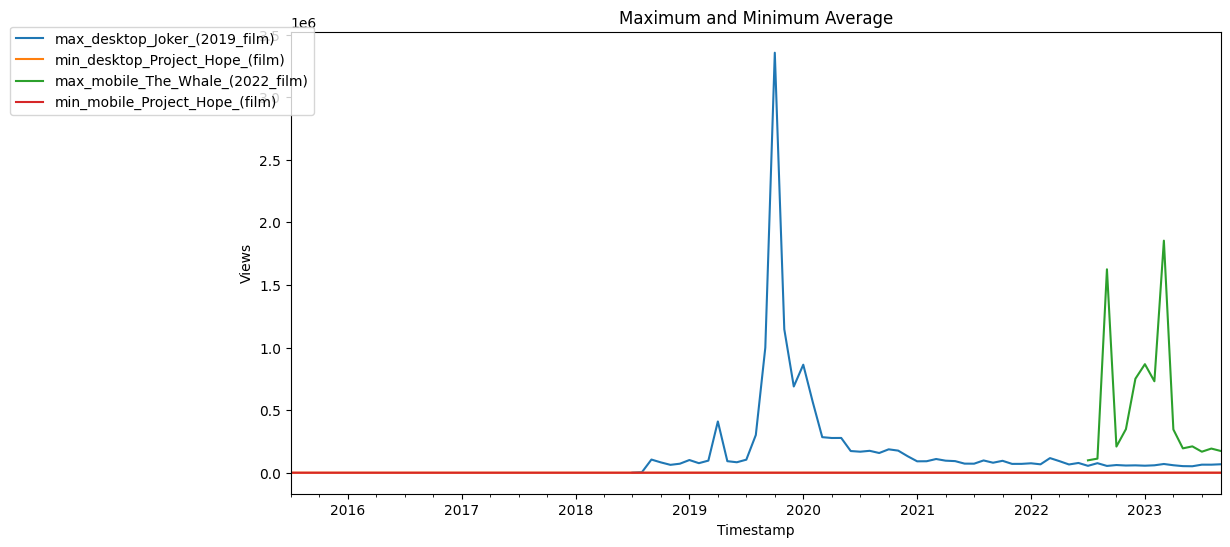

In [223]:
fig, ax1 = plt.subplots(figsize=(12, 6))
max_desktop_df = visualization_df[visualization_df['min_max']=='max_desktop']
max_desktop_df['views'].plot(label = max_desktop_df['label'].value_counts().index[0])
min_desktop_df = df_main[df_main['min_max']=='min_desktop']
min_desktop_df['views'].plot(label = min_desktop_df['label'].value_counts().index[0])
max_mobile_df = df_main[df_main['min_max']=='max_mobile']
max_mobile_df['views'].plot(label = max_mobile_df['label'].value_counts().index[0])
min_mobile_df = df_main[df_main['min_max']=='min_mobile']
min_mobile_df['views'].plot(label = min_mobile_df['label'].value_counts().index[0])
plt.title('Maximum and Minimum Average')
plt.xlabel('Timestamp')
plt.ylabel('Views')
fig.legend(loc="upper right", bbox_to_anchor=(0.15, 0.9))
plt.show()
plt.savefig('../Output and Results/Max_Min_plot.png')
plt.close()

# Second Analysis

In [207]:
def top_10_views_function(df, access):
    grouped = df.groupby('article').max('views').reset_index()
    grouped = grouped.sort_values(by='views', ascending=False)
    top10 = grouped.head(10)
    top10 = top10[['article']].reset_index(drop=True)
    top10['rank'] = pd.Series(np.arange(1,11))
    df['access'] = access
    df = df[['timestamp', 'article', 'access', 'views']]
    df = df.merge(top10, on='article', how='inner')
    df['label'] = 'Rank' + df['rank'].astype('str') + access + '_' + df['article']
    return df
top_desktop = top_10_views_function(desktop, 'desktop')
top_mobile = top_10_views_function(mobile, 'mobile')
df_final = pd.concat([top_desktop, top_mobile])
df_final = df_final.set_index('timestamp')

### Visualization

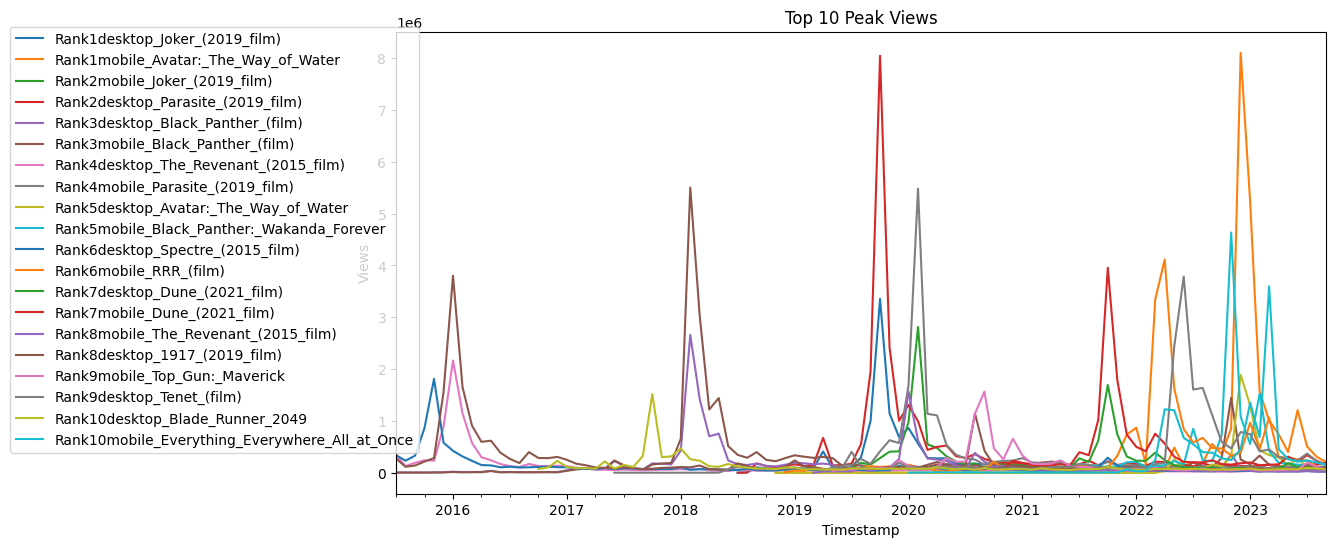

In [208]:
fig, ax1 = plt.subplots(figsize=(12, 6))
for i in range(1,11):
    df = df_final[df_final['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['label'].value_counts().index[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['label'].value_counts().index[1])
plt.title('Top 10 Peak Views')
plt.xlabel('Timestamp')
plt.ylabel('Views')
fig.legend(loc="upper right", bbox_to_anchor=(0.15, 0.9))
plt.show()
plt.savefig('../Output and Results/Top10_plot.png')
plt.close()

# Third Analysis

In [202]:
def fewest_months_function(df, access):
    least_month_df = df.groupby("article").count().reset_index()
    least_month_df = least_month_df[['article', 'views']]
    least_month_df = least_month_df.sort_values(by='views', ascending=True)
    lease_10 = least_month_df.head(10)
    lease_10 = lease_10[['article']].reset_index()
    lease_10 = lease_10.drop('index', axis = 1)
    lease_10['rank'] = pd.Series(np.arange(1,11))
    df['access'] = access
    df = df[['timestamp', 'article', 'access', 'views']]
    df = df.merge(lease_10, on='article', how='inner', suffixes=('_left', '_right'))
    df['label'] = 'Rank' + df['rank'].astype('str') + access + '_' + df['article']
    return df
top_desktop = fewest_months_function(desktop, 'desktop')
top_mobile = fewest_months_function(mobile, 'mobile')
df_final = pd.concat([top_desktop, top_mobile])
df_final = df_final.set_index('timestamp')

### Visualization

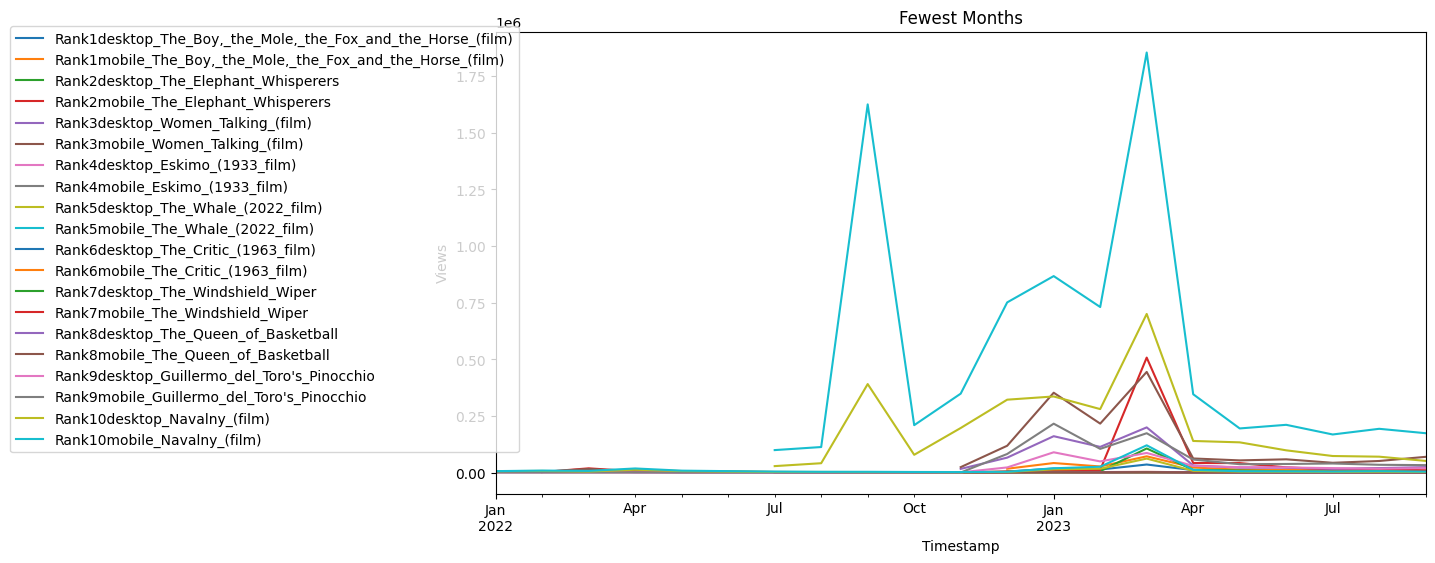

In [203]:
fig, ax1 = plt.subplots(figsize=(12, 6))
for i in range(1,11):
    df = df_final[df_final['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['label'].value_counts().index[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['label'].value_counts().index[1])
plt.title('Fewest Months')
plt.xlabel('Timestamp')
plt.ylabel('Views')
fig.legend(loc="upper right", bbox_to_anchor=(0.15, 0.9))
plt.show()
plt.savefig('../Output and Results/Fewest10_plot.png')
plt.close()